# Text Embeddings and Vector Search with Weaviate

## Yale AI Research Techniques Workshop
### July 2, 2025

In this notebook, we'll explore:
- How text embeddings encode semantic meaning
- Building a vector database with Weaviate
- Applying embeddings to entity resolution in library catalogs
- Visualizing semantic relationships in vector space

## 1. Setup and Installation

First, let's install the required packages and set up our environment.

In [1]:
# Install required packages
!pip install -q weaviate-client openai numpy pandas matplotlib seaborn scikit-learn plotly


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [4]:
# Import necessary libraries
import os
import json
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
import warnings

# Weaviate and OpenAI imports
import weaviate
from weaviate.classes.config import Configure, Property, DataType, VectorDistances
from weaviate.classes.query import Filter
from openai import OpenAI
warnings.filterwarnings('ignore')

# Set visual style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [6]:
# Set up API keys (you'll need to add your own)
#from google.colab import userdata

# Get OpenAI API key from Colab secrets
#os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

# Initialize OpenAI client
openai_client = OpenAI(api_key=os.environ['OPENAI_API_KEY'])

## 2. Understanding Text Embeddings

Text embeddings are numerical representations of text that capture semantic meaning. Words or phrases with similar meanings have similar vector representations.

In [7]:
# Let's create embeddings for some simple examples
def get_embedding(text: str) -> np.ndarray:
    """Get embedding for a single text using OpenAI's API."""
    response = openai_client.embeddings.create(
        model="text-embedding-3-small",
        input=text
    )
    return np.array(response.data[0].embedding)

# Example texts
texts = [
    "Schubert, Franz, 1797-1828",  # The composer
    "Schubert, Franz August, 1805-1893",  # The artist
    "Mozart, Wolfgang Amadeus, 1756-1791",  # Another composer
    "Photography in archaeology",  # Subject
    "Fotografía en arqueología",  # Same subject in Spanish
    "Fotografia em arqueologia"  # Same subject in Portuguese
]

# Generate embeddings
embeddings = {}
for text in texts:
    embeddings[text] = get_embedding(text)
    print(f"✓ Generated embedding for: {text}")
    print(f"  Embedding shape: {embeddings[text].shape}")
    print(f"  First 5 values: {embeddings[text][:5]}\n")

✓ Generated embedding for: Schubert, Franz, 1797-1828
  Embedding shape: (1536,)
  First 5 values: [-0.05880579 -0.06004467  0.00862058  0.00271522  0.0260166 ]

✓ Generated embedding for: Schubert, Franz August, 1805-1893
  Embedding shape: (1536,)
  First 5 values: [-0.04930551 -0.05913316  0.00303193  0.01208591  0.02925293]

✓ Generated embedding for: Mozart, Wolfgang Amadeus, 1756-1791
  Embedding shape: (1536,)
  First 5 values: [-0.01378516 -0.01857607  0.01263263  0.03425952  0.00567508]

✓ Generated embedding for: Photography in archaeology
  Embedding shape: (1536,)
  First 5 values: [ 0.0117437   0.00789923 -0.01537787 -0.00877327 -0.04700109]

✓ Generated embedding for: Fotografía en arqueología
  Embedding shape: (1536,)
  First 5 values: [ 0.00390061  0.00691184 -0.02545139  0.00825139 -0.05257172]

✓ Generated embedding for: Fotografia em arqueologia
  Embedding shape: (1536,)
  First 5 values: [-0.00036724  0.00777096 -0.01854713  0.02493883 -0.03577108]



## 3. Measuring Semantic Similarity

We use cosine similarity to measure how similar two embeddings are. Values range from -1 (opposite) to 1 (identical).

Cosine Similarity Matrix:



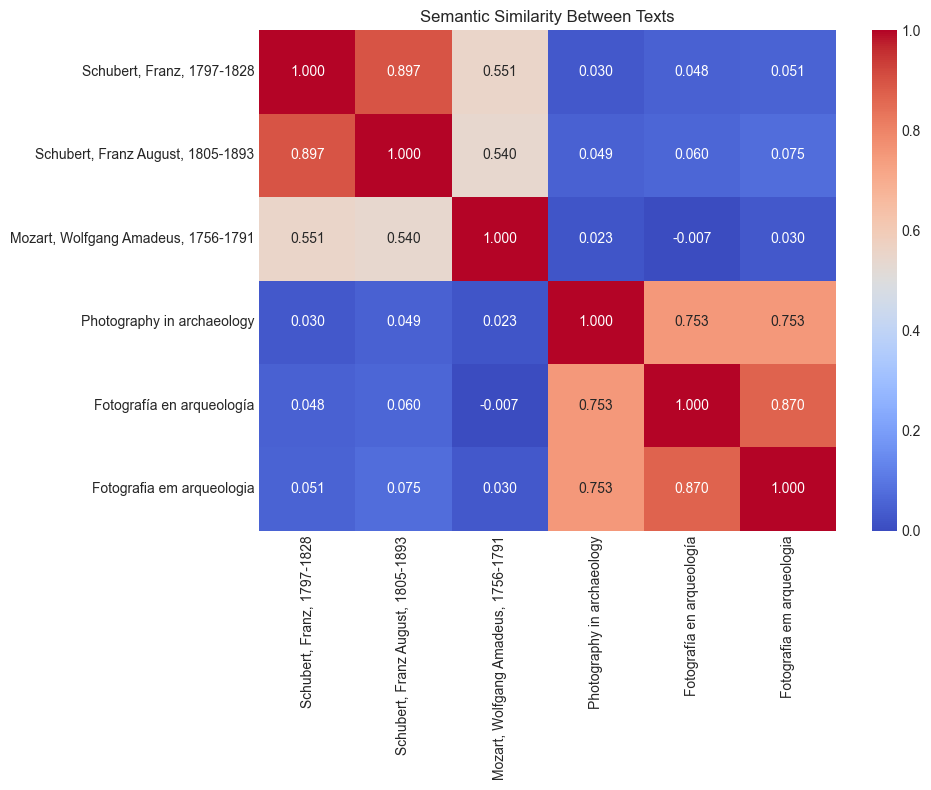

In [8]:
# Calculate cosine similarity
def cosine_similarity(vec1: np.ndarray, vec2: np.ndarray) -> float:
    """Calculate cosine similarity between two vectors."""
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    return dot_product / (norm1 * norm2)

# Compare all pairs
print("Cosine Similarity Matrix:\n")
similarity_matrix = pd.DataFrame(index=texts, columns=texts)

for i, text1 in enumerate(texts):
    for j, text2 in enumerate(texts):
        sim = cosine_similarity(embeddings[text1], embeddings[text2])
        similarity_matrix.iloc[i, j] = sim

# Display as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix.astype(float), annot=True, fmt='.3f', 
            cmap='coolwarm', center=0.5, vmin=0, vmax=1)
plt.title('Semantic Similarity Between Texts')
plt.tight_layout()
plt.show()

### Key Observations:
- The two Franz Schuberts have high similarity despite being different people
- Multilingual translations of the same concept have very high similarity
- This demonstrates both the power and challenges of embeddings for entity resolution

## 4. Setting Up Weaviate Vector Database

Weaviate is a vector database that allows us to store and search embeddings efficiently.

In [9]:
# Connect to Weaviate (using embedded instance for simplicity)
# In production, you would connect to a hosted instance
weaviate_client = weaviate.connect_to_embedded(
    version="1.24.1",
    environment_variables={
        "OPENAI_APIKEY": os.environ['OPENAI_API_KEY']
    }
)

print("✓ Connected to Weaviate")

{"action":"startup","default_vectorizer_module":"none","level":"info","msg":"the default vectorizer modules is set to \"none\", as a result all new schema classes without an explicit vectorizer setting, will use this vectorizer","time":"2025-06-30T20:38:14-04:00"}
{"action":"startup","auto_schema_enabled":true,"level":"info","msg":"auto schema enabled setting is set to \"true\"","time":"2025-06-30T20:38:14-04:00"}
{"level":"info","msg":"No resource limits set, weaviate will use all available memory and CPU. To limit resources, set LIMIT_RESOURCES=true","time":"2025-06-30T20:38:14-04:00"}
{"level":"warning","msg":"Multiple vector spaces are present, GraphQL Explore and REST API list objects endpoint module include params has been disabled as a result.","time":"2025-06-30T20:38:14-04:00"}
{"action":"grpc_startup","level":"info","msg":"grpc server listening at [::]:50050","time":"2025-06-30T20:38:14-04:00"}
{"action":"restapi_management","level":"info","msg":"Serving weaviate at http://12

✓ Connected to Weaviate


{"action":"telemetry_push","level":"info","msg":"telemetry started","payload":"\u0026{MachineID:c48014f9-80bc-4fe9-a558-748a1f9c463e Type:INIT Version:1.24.1 Modules:generative-openai,qna-openai,ref2vec-centroid,reranker-cohere,text2vec-cohere,text2vec-huggingface,text2vec-openai NumObjects:0 OS:darwin Arch:arm64}","time":"2025-06-30T20:38:14-04:00"}
{"action":"read_disk_use","level":"warning","msg":"disk usage currently at 84.43%, threshold set to 80.00%","path":"/Users/tt434/.local/share/weaviate","time":"2025-06-30T20:38:14-04:00"}


In [10]:
# Create collection schema
# First, delete if exists (for clean reruns)
try:
    weaviate_client.collections.delete("CatalogString")
    print("Deleted existing collection")
except:
    print("No existing collection to delete")

# Create new collection with OpenAI vectorizer
collection = weaviate_client.collections.create(
    name="CatalogString",
    description="Collection for catalog string values with their embeddings",
    vectorizer_config=Configure.Vectorizer.text2vec_openai(
        model="text-embedding-3-small",
        dimensions=1536
    ),
    vector_index_config=Configure.VectorIndex.hnsw(
        ef=128,
        max_connections=64,
        ef_construction=128,
        distance_metric=VectorDistances.COSINE
    ),
    properties=[
        Property(name="original_string", data_type=DataType.TEXT),
        Property(name="field_type", data_type=DataType.TEXT),
        Property(name="person_id", data_type=DataType.TEXT),
        Property(name="title", data_type=DataType.TEXT),
        Property(name="subjects", data_type=DataType.TEXT),
        Property(name="composite", data_type=DataType.TEXT)
    ]
)

print("✓ Created CatalogString collection")

Deleted existing collection
✓ Created CatalogString collection


{"level":"info","msg":"Created shard catalogstring_ylMrLe6NVGj9 in 2.682458ms","time":"2025-06-30T20:38:36-04:00"}
{"action":"hnsw_vector_cache_prefill","count":1000,"index_id":"main","level":"info","limit":1000000000000,"msg":"prefilled vector cache","time":"2025-06-30T20:38:36-04:00","took":44542}
{"action":"read_disk_use","level":"warning","msg":"disk usage currently at 84.43%, threshold set to 80.00%","path":"/Users/tt434/.local/share/weaviate","time":"2025-06-30T20:38:45-04:00"}


## 5. Indexing Library Catalog Data

Let's create a diverse sample dataset of library catalog records.

In [11]:
# Create sample library catalog data
catalog_data = [
    # Franz Schubert - the composer
    {
        "person": "Schubert, Franz, 1797-1828",
        "title": "Symphony No. 8 in B minor 'Unfinished'",
        "subjects": "Symphonies; Romantic music",
        "composite": "Contributor: Schubert, Franz, 1797-1828\nTitle: Symphony No. 8 in B minor 'Unfinished'\nSubjects: Symphonies; Romantic music",
        "person_id": "12345#Agent700-1",
        "field_type": "person"
    },
    # Franz August Schubert - the artist  
    {
        "person": "Schubert, Franz August, 1805-1893",
        "title": "Archäologie und Photographie: fünfzig Beispiele zur Geschichte und Methode",
        "subjects": "Photography in archaeology",
        "composite": "Contributor: Schubert, Franz August, 1805-1893\nTitle: Archäologie und Photographie\nSubjects: Photography in archaeology",
        "person_id": "53144#Agent700-22",
        "field_type": "person"
    },
    # Spanish example - female author
    {
        "person": "García Lorca, Federico, 1898-1936",
        "title": "Romancero gitano",
        "subjects": "Poesía española; Literatura del siglo XX",
        "composite": "Contributor: García Lorca, Federico, 1898-1936\nTitle: Romancero gitano\nSubjects: Poesía española; Literatura del siglo XX",
        "person_id": "67890#Agent700-3",
        "field_type": "person"
    },
    # Portuguese example - female scientist
    {
        "person": "Mello, Margarida, 1950-",
        "title": "Métodos computacionais em arqueologia brasileira",
        "subjects": "Arqueologia computacional; Brasil",
        "composite": "Contributor: Mello, Margarida, 1950-\nTitle: Métodos computacionais em arqueologia brasileira\nSubjects: Arqueologia computacional; Brasil",
        "person_id": "78901#Agent700-4",
        "field_type": "person"
    },
    # Another archaeology work for comparison
    {
        "person": "Smith, Jennifer, 1975-",
        "title": "Digital Methods in Archaeological Documentation",
        "subjects": "Digital archaeology; Photography",
        "composite": "Contributor: Smith, Jennifer, 1975-\nTitle: Digital Methods in Archaeological Documentation\nSubjects: Digital archaeology; Photography",
        "person_id": "89012#Agent700-5",
        "field_type": "person"
    },
    # Classical music for similarity
    {
        "person": "Mozart, Wolfgang Amadeus, 1756-1791",
        "title": "Requiem in D minor, K. 626",
        "subjects": "Requiems; Classical music",
        "composite": "Contributor: Mozart, Wolfgang Amadeus, 1756-1791\nTitle: Requiem in D minor, K. 626\nSubjects: Requiems; Classical music",
        "person_id": "90123#Agent700-6",
        "field_type": "person"
    }
]

print(f"Created {len(catalog_data)} catalog records")
for record in catalog_data:
    print(f"  • {record['person']} - {record['title'][:50]}...")

Created 6 catalog records
  • Schubert, Franz, 1797-1828 - Symphony No. 8 in B minor 'Unfinished'...
  • Schubert, Franz August, 1805-1893 - Archäologie und Photographie: fünfzig Beispiele zu...
  • García Lorca, Federico, 1898-1936 - Romancero gitano...
  • Mello, Margarida, 1950- - Métodos computacionais em arqueologia brasileira...
  • Smith, Jennifer, 1975- - Digital Methods in Archaeological Documentation...
  • Mozart, Wolfgang Amadeus, 1756-1791 - Requiem in D minor, K. 626...


In [12]:
# Index data into Weaviate
print("Indexing catalog records...\n")

with collection.batch.dynamic() as batch:
    for record in catalog_data:
        # Add the record - Weaviate will automatically generate embeddings
        batch.add_object(
            properties={
                "original_string": record["person"],
                "field_type": record["field_type"],
                "person_id": record["person_id"],
                "title": record["title"],
                "subjects": record["subjects"],
                "composite": record["composite"]
            }
        )
        print(f"✓ Indexed: {record['person']}")

print(f"\n✓ Successfully indexed {len(catalog_data)} records")

Indexing catalog records...

✓ Indexed: Schubert, Franz, 1797-1828
✓ Indexed: Schubert, Franz August, 1805-1893
✓ Indexed: García Lorca, Federico, 1898-1936
✓ Indexed: Mello, Margarida, 1950-
✓ Indexed: Smith, Jennifer, 1975-
✓ Indexed: Mozart, Wolfgang Amadeus, 1756-1791

✓ Successfully indexed 6 records


## 6. Vector Similarity Search

Now let's search for similar entities using vector similarity.

In [13]:
# Search for entities similar to "Schubert, Franz"
search_text = "Schubert, Franz"
search_embedding = get_embedding(search_text)

print(f"Searching for entities similar to: '{search_text}'\n")

# Perform near_vector search
results = collection.query.near_vector(
    near_vector=search_embedding.tolist(),
    limit=5,
    return_properties=["original_string", "title", "subjects", "person_id"],
    return_metadata=["distance"]
)

# Display results
print("Search Results (ordered by similarity):\n")
for i, obj in enumerate(results.objects):
    similarity = 1 - obj.metadata.distance  # Convert distance to similarity
    print(f"{i+1}. {obj.properties['original_string']}")
    print(f"   Similarity: {similarity:.4f}")
    print(f"   Title: {obj.properties['title']}")
    print(f"   Subjects: {obj.properties['subjects']}")
    print(f"   ID: {obj.properties['person_id']}")
    print()

Searching for entities similar to: 'Schubert, Franz'

Search Results (ordered by similarity):

1. Schubert, Franz, 1797-1828
   Similarity: 0.5845
   Title: Symphony No. 8 in B minor 'Unfinished'
   Subjects: Symphonies; Romantic music
   ID: 12345#Agent700-1

2. Schubert, Franz August, 1805-1893
   Similarity: 0.5095
   Title: Archäologie und Photographie: fünfzig Beispiele zur Geschichte und Methode
   Subjects: Photography in archaeology
   ID: 53144#Agent700-22

3. Mozart, Wolfgang Amadeus, 1756-1791
   Similarity: 0.3993
   Title: Requiem in D minor, K. 626
   Subjects: Requiems; Classical music
   ID: 90123#Agent700-6

4. García Lorca, Federico, 1898-1936
   Similarity: 0.2406
   Title: Romancero gitano
   Subjects: Poesía española; Literatura del siglo XX
   ID: 67890#Agent700-3

5. Mello, Margarida, 1950-
   Similarity: 0.1373
   Title: Métodos computacionais em arqueologia brasileira
   Subjects: Arqueologia computacional; Brasil
   ID: 78901#Agent700-4



{"action":"read_disk_use","level":"warning","msg":"disk usage currently at 84.43%, threshold set to 80.00%","path":"/Users/tt434/.local/share/weaviate","time":"2025-06-30T20:40:45-04:00"}


## 7. Entity Resolution Challenge

Notice how both Franz Schuberts appear as highly similar! This demonstrates the entity resolution challenge in library catalogs.

In [ ]:
# Let's search specifically for archaeology-related works
archaeology_embedding = get_embedding("archaeology photography digital methods")

print("Searching for archaeology-related works:\n")

# Search with filter
results = collection.query.near_vector(
    near_vector=archaeology_embedding.tolist(),
    limit=5,
    return_properties=["original_string", "title", "subjects"],
    return_metadata=["distance"]
)

for i, obj in enumerate(results.objects):
    similarity = 1 - obj.metadata.distance
    print(f"{i+1}. {obj.properties['original_string']}")
    print(f"   Similarity: {similarity:.4f}")
    print(f"   Title: {obj.properties['title'][:60]}...")
    print()

## 8. Multilingual Semantic Search

Text embeddings can capture meaning across languages.

In [ ]:
# Search in English for works that might be in other languages
multilingual_searches = [
    ("computational archaeology", "English"),
    ("arqueología computacional", "Spanish"),
    ("arqueologia computacional", "Portuguese")
]

print("Cross-lingual semantic search:\n")

for search_term, language in multilingual_searches:
    print(f"Searching with '{search_term}' ({language}):\n")
    
    search_embedding = get_embedding(search_term)
    results = collection.query.near_vector(
        near_vector=search_embedding.tolist(),
        limit=3,
        return_properties=["original_string", "title"],
        return_metadata=["distance"]
    )
    
    for obj in results.objects:
        similarity = 1 - obj.metadata.distance
        print(f"  • {obj.properties['title'][:60]}... (similarity: {similarity:.3f})")
    print()

## 9. Visualizing Vector Space

Let's visualize how our catalog entries are distributed in vector space.

In [ ]:
# Extract all vectors from our collection
all_results = collection.query.fetch_objects(
    limit=100,
    include_vector=True,
    return_properties=["original_string", "title", "subjects"]
)

# Prepare data for visualization
vectors = []
labels = []
titles = []
subjects = []

for obj in all_results.objects:
    if hasattr(obj, 'vector') and obj.vector:
        # Handle both dict and direct vector formats
        if isinstance(obj.vector, dict) and 'default' in obj.vector:
            vectors.append(obj.vector['default'])
        else:
            vectors.append(obj.vector)
        
        labels.append(obj.properties['original_string'])
        titles.append(obj.properties['title'][:40] + '...')
        subjects.append(obj.properties['subjects'])

vectors = np.array(vectors)
print(f"Extracted {len(vectors)} vectors for visualization")

In [ ]:
# Reduce dimensions using t-SNE for 2D visualization
print("Reducing dimensions with t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
vectors_2d = tsne.fit_transform(vectors)

# Create interactive plot with Plotly
fig = go.Figure()

# Add scatter points
fig.add_trace(go.Scatter(
    x=vectors_2d[:, 0],
    y=vectors_2d[:, 1],
    mode='markers+text',
    marker=dict(
        size=12,
        color=list(range(len(labels))),
        colorscale='Viridis',
        showscale=False
    ),
    text=labels,
    textposition="top center",
    hovertemplate='<b>%{text}</b><br>' +
                  'Title: %{customdata[0]}<br>' +
                  'Subjects: %{customdata[1]}<br>' +
                  '<extra></extra>',
    customdata=list(zip(titles, subjects))
))

# Update layout
fig.update_layout(
    title="Library Catalog Entries in Vector Space (t-SNE)",
    xaxis_title="t-SNE Dimension 1",
    yaxis_title="t-SNE Dimension 2",
    width=900,
    height=600,
    showlegend=False
)

fig.show()

In [ ]:
# Alternative visualization with PCA
print("Creating PCA visualization...")
pca = PCA(n_components=2)
vectors_pca = pca.fit_transform(vectors)

# Create static matplotlib plot
plt.figure(figsize=(12, 8))

# Color by subject area
subject_colors = {
    'music': 'blue',
    'archaeology': 'green',
    'photography': 'orange',
    'literatura': 'red',
    'arqueologia': 'green'
}

colors = []
for subj in subjects:
    color = 'gray'
    for key, col in subject_colors.items():
        if key in subj.lower():
            color = col
            break
    colors.append(color)

plt.scatter(vectors_pca[:, 0], vectors_pca[:, 1], c=colors, s=100, alpha=0.7)

# Add labels
for i, label in enumerate(labels):
    plt.annotate(label, (vectors_pca[i, 0], vectors_pca[i, 1]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.title('Library Catalog Entries in Vector Space (PCA)', fontsize=16)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.grid(True, alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=col, label=key.capitalize()) 
                  for key, col in subject_colors.items()]
plt.legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.show()

print(f"\nPCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.2%}")

## 10. Entity Resolution in Practice

Let's demonstrate how vector similarity can help with entity resolution, but also where additional features are needed.

In [ ]:
# Get embeddings for our two Schuberts
schubert_composer = next(r for r in catalog_data if "1797-1828" in r["person"])
schubert_artist = next(r for r in catalog_data if "1805-1893" in r["person"])

# Calculate similarities for different fields
fields_to_compare = ['person', 'title', 'subjects', 'composite']

print("Entity Resolution Analysis: Two Franz Schuberts\n")
print("Composer:", schubert_composer['person'])
print("Artist:", schubert_artist['person'])
print("\nField-by-field similarity comparison:\n")

similarities = {}
for field in fields_to_compare:
    if field in schubert_composer and field in schubert_artist:
        emb1 = get_embedding(schubert_composer[field])
        emb2 = get_embedding(schubert_artist[field])
        sim = cosine_similarity(emb1, emb2)
        similarities[field] = sim
        print(f"{field.capitalize():12} similarity: {sim:.4f}")

# Visualize similarities
plt.figure(figsize=(10, 6))
fields = list(similarities.keys())
values = list(similarities.values())

bars = plt.bar(fields, values, color=['red', 'blue', 'green', 'purple'])
plt.ylim(0, 1)
plt.ylabel('Cosine Similarity')
plt.title('Field-wise Similarity: Franz Schubert (Composer) vs Franz August Schubert (Artist)')
plt.axhline(y=0.7, color='r', linestyle='--', label='Typical threshold')

# Add value labels on bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center')

plt.legend()
plt.tight_layout()
plt.show()

print("\n💡 Key Insight: High name similarity but very different contexts!")
print("   This is why entity resolution needs multiple signals beyond just name matching.")

## 11. Practical Tips for Entity Resolution

Based on our exploration, here are key strategies for entity resolution with embeddings:

In [ ]:
# Demonstrate a simple entity resolution strategy
def entity_resolution_score(record1, record2, weights=None):
    """Calculate weighted similarity score for entity resolution."""
    if weights is None:
        weights = {
            'person': 0.4,
            'title': 0.2,
            'subjects': 0.2,
            'composite': 0.2
        }
    
    total_score = 0
    for field, weight in weights.items():
        if field in record1 and field in record2:
            emb1 = get_embedding(record1[field])
            emb2 = get_embedding(record2[field])
            similarity = cosine_similarity(emb1, emb2)
            total_score += weight * similarity
    
    return total_score

# Test on all pairs
print("Entity Resolution Scores (using weighted features):\n")

threshold = 0.7
matches = []

for i in range(len(catalog_data)):
    for j in range(i+1, len(catalog_data)):
        score = entity_resolution_score(catalog_data[i], catalog_data[j])
        
        if score > threshold:
            matches.append((catalog_data[i]['person'], catalog_data[j]['person'], score))
            print(f"Potential match: {catalog_data[i]['person'][:30]:30} ↔ {catalog_data[j]['person'][:30]:30} | Score: {score:.3f}")

if not matches:
    print(f"No matches found above threshold {threshold}")
    print("\nTop similarities:")
    
    all_scores = []
    for i in range(len(catalog_data)):
        for j in range(i+1, len(catalog_data)):
            score = entity_resolution_score(catalog_data[i], catalog_data[j])
            all_scores.append((catalog_data[i]['person'], catalog_data[j]['person'], score))
    
    all_scores.sort(key=lambda x: x[2], reverse=True)
    for p1, p2, score in all_scores[:3]:
        print(f"  {p1[:30]:30} ↔ {p2[:30]:30} | Score: {score:.3f}")

## 12. Key Takeaways

1. **Text embeddings capture semantic meaning**: Similar concepts have similar vectors
2. **Multilingual understanding**: Modern embeddings work across languages
3. **Entity resolution challenges**: Name similarity alone isn't enough
4. **Context matters**: Combining multiple fields improves accuracy
5. **Vector databases enable fast search**: Weaviate makes similarity search efficient

### Next Steps
- Experiment with different similarity thresholds
- Try the Mistral AI Classifier Factory for classification tasks
- Explore hot-deck imputation for missing metadata
- Scale to larger datasets with batch processing

In [ ]:
# Clean up
weaviate_client.close()
print("✓ Closed Weaviate connection")